In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import time
from drone_vrp import*

#### Replace the Fitness(population[i]).routeDistance() to our own objective function. ####
#### Replace  otherParamters to our own parameters which needed to initial and caculate the objective function

#### Population will be the list of customer service station route ####

#### Fitness(population[i]).routeDistance() will be the service time from route ####

#### So that  fitnessResults will be list the 1/serviceTime from the list of route ####

In [2]:
def rankRoutes(population, dvrp):
    fitnessResults = {}
    for i in range(0,len(population)):
        print('population id:')
        for custom in population[i]:
            print(custom.id)
        dvrp1 = copy.deepcopy(dvrp)
        dvrp1.customers = population[i]
        dvrp1.split_route();
        fitnessResults[i] = 1/dvrp1.objective()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

#### Main method of GA, please replace the otherParamters with our own Parameters need####

next gen 100 parent -> spiltroute for each parent -> 100 results -> rankResult -> 20 best parent +80 child -> 100 child ->1% mutate -> next gen 100 parent -> loop

Mutate 1% (city1, city2 ..... cityn) -> mutate (city1, cityn ..... city2)

loop next gen 500 -> 100 gens ->best 1 output

In [3]:
'''
Description: Main method of GA
Reference: 
https://levelup.gitconnected.com/how-to-implement-a-traveling-salesman-problem-genetic-algorithm-in-python-ea32c7bef20f
https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35
https://github.com/rocreguant/personal_blog/blob/main/Genetic_Algorithm_Python_Example/Traveling_Salesman_Problem.ipynb
https://github.com/ezstoltz/genetic-algorithm/blob/master/genetic_algorithm_TSP.ipynb

'''

## Create our initial population
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    
    return route

#Create first "population" (list of routes)
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

#Create mating pool
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

#Create a crossover function for two parents to create one child
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

#Create a crossover function for two parents to create one child
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

#Create function to run crossover over full mating pool
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

#Create function to mutate a single route
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

#Create function to run mutation over entire population
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

#Put all steps together to create the next generation
def nextGeneration(currentGen, eliteSize, mutationRate, otherParamters):
    popRanked = rankRoutes(currentGen, otherParamters)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

#Final step: create the genetic algorithm
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations, dvrp):
    print(population)
    pop = initialPopulation(popSize, population)
    print("Initial Service Time: " + str(1 / rankRoutes(pop, dvrp)[0][1]))
    progress = []
    progress.append(1 / rankRoutes(pop, dvrp)[0][1])
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate, dvrp)
        progress.append(1 / rankRoutes(pop, dvrp)[0][1])
    
    print("Final Service Time: " + str(1 / rankRoutes(pop, dvrp)[0][1]))
    plt.plot(progress)
    plt.ylabel('Service Time')
    plt.xlabel('Generation')
    plt.show()
    bestRouteIndex = rankRoutes(pop, dvrp)[0][0]
    bestRoute = pop[bestRouteIndex]
    dvrp1 = copy.deepcopy(dvrp)
    dvrp1.customers = bestRoute
    dvrp1.split_route();
    
    return dvrp1


## Running the genetic algorithm

### Please replace the cityList with our own Customers Service Satation from either hardcode or data import,
### Please replace the otherParamters with our own Parameters needed for mode from either hardcode or data import

[<drone_vrp.Customer object at 0x0000028548F4BCA0>, <drone_vrp.Customer object at 0x0000028548F4B790>, <drone_vrp.Customer object at 0x0000028548F4B670>]
population id:
2
1
0
population id:
1
0
2
population id:
2
1
0
Initial Service Time: 15.0
population id:
2
1
0
population id:
1
0
2
population id:
2
1
0
population id:
2
1
0
population id:
1
0
2
population id:
2
1
0
population id:
1
0
2
population id:
1
0
2
population id:
2
1
0
population id:
1
0
2
population id:
1
0
2
population id:
2
1
0
population id:
1
0
2
population id:
1
0
2
population id:
2
1
0
population id:
1
0
2
population id:
1
0
2
population id:
2
1
0
population id:
1
0
2
population id:
1
0
2
population id:
1
0
2
population id:
1
0
2
population id:
1
0
2
population id:
1
0
2
population id:
1
0
2
population id:
1
0
2
population id:
1
0
2
population id:
1
0
2
population id:
1
0
2
population id:
1
0
2
population id:
1
0
2
population id:
1
0
2
population id:
1
0
2
population id:
1
0
2
population id:
1
0
2
population id:
1
0
2


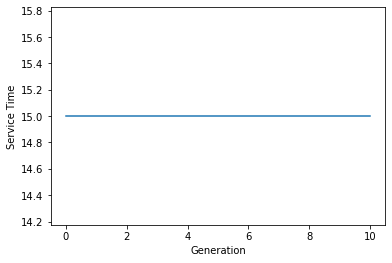

population id:
1
0
2
population id:
0
1
2
population id:
0
1
2
running time:  3.0966501235961914
bestRoute: 


TypeError: 'DVRP' object is not iterable

In [6]:
if __name__ == '__main__':
    #cityList = []
    
    #replace this part with out service Statoin List!
    #for i in range(0,25):
    #    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))
    #otherParamters = 'otherParamters'
    #end of replacement!
    
    
    
    #replacement now
    #warehouses, customers, trucks, drones, map_size = #parse mehtod
    
    warehouses = [
        Warehouse(
            id=0,
            type=0,
            x=0,
            y=0
        ),
        Warehouse(
            id=1,
            type=0,
            x=6,
            y=6
        ),
        Warehouse(
            id=2,
            type=0,
            x=-6,
            y=-6
        )
    ]

    customers = [
        Customer(
            id=0,
            type=1,
            x=2,
            y=2,
            demand=1
        ),
        Customer(
            id=1,
            type=1,
            x=1,
            y=1,
            demand=1
        ),
        Customer(
            id=2,
            type=1,
            x=3,
            y=1,
            demand=1
        )
    ]
    
    trucks = [
        Truck(
            id=0,
            start_node=warehouses[0],
            speed_factor=1
            
        )
    ]

    drones = [
        Drone(
            id=0,
            start_node=warehouses[0],
            speed_factor=1,
            item_capacity=1,
            battery_capacity=5,
            consumption_rate=1,
            charging_speed=5
        )
    ]

    dvrp = DVRP(warehouses=warehouses, customers=customers, trucks=trucks, drones=drones, map_size=100)
    
   
    #end of the replacement now
    
    start = time.time()

    
    DVRP = geneticAlgorithm(population=customers, popSize=3, eliteSize=1, mutationRate=0.01, generations=10,dvrp=dvrp)
    
    end = time.time()
    print('running time: ',end - start)
    

popSize*generations*hur